# RentHop - Model 1

"""
Author - Lily Elizabeth John
Date - 04/19/2017
Project - Kaggle - Renthop - Women Who Code - Workshop
Project Description : To predict interest level (Low, Medium, high) for listings. The dataset was provided by Two Sigma and Renthop.
"""

### Import Libraries

In [78]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

#Import metrics libraries
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

#Import CV libraries
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import Imputer

#Import Clustering Libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#Import model libraries
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

## Read Data

In [3]:
#Read Data
train_df=pd.read_json("C:/Users/ljohn/Documents/2017/Personal/WWC - Kaggle/Exploring Train.JSON/train.json")
test_df=pd.read_json("C:/Users/ljohn/Documents/2017/Personal/WWC - Kaggle/Exploring Train.JSON/test.json")

In [4]:
train_df.shape

(49352, 15)

In [5]:
train_df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [6]:
test_df.shape

(74659, 14)

## Exclude Price Outliers

In [7]:
#Exclude price outliers from training data
ulimit = np.percentile(train_df.price.values, 99)
train_df=train_df[train_df['price']<ulimit]

In [8]:
#Exclude Latitude longitude outliers from training data
outlier_mask = ( (train_df.latitude < 40.6) | (train_df.latitude > 40.9) | 
                 (train_df.longitude < -74.1) | (train_df.longitude > -73.8) )
train_df = train_df.drop(train_df.index[outlier_mask], axis=0)

## Combine Train and Test datasets to perform feature engineering

In [9]:
#Combine test and train dataset for feature engineering
train_df['test']=False
test_df['test']=True

cdf=train_df.append(test_df).reset_index(drop=True)
cdf.shape

(123265, 16)

In [10]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123265 entries, 0 to 123264
Data columns (total 16 columns):
bathrooms          123265 non-null float64
bedrooms           123265 non-null int64
building_id        123265 non-null object
created            123265 non-null object
description        123265 non-null object
display_address    123265 non-null object
features           123265 non-null object
interest_level     48606 non-null object
latitude           123265 non-null float64
listing_id         123265 non-null int64
longitude          123265 non-null float64
manager_id         123265 non-null object
photos             123265 non-null object
price              123265 non-null int64
street_address     123265 non-null object
test               123265 non-null bool
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 14.2+ MB


## Extract lat and long for Unsupervised Learning using clusters

In [11]:
x=cdf[['latitude','longitude']]

In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123265 entries, 0 to 123264
Data columns (total 2 columns):
latitude     123265 non-null float64
longitude    123265 non-null float64
dtypes: float64(2)
memory usage: 1.9 MB


In [120]:
#Identify 100 geographical clusters
n_clusters=100

In [14]:
kmeans = KMeans(n_clusters).fit(x)
kmeans.labels_

array([30, 19, 60, ..., 21, 11, 30])

In [15]:
kmeans.labels_.shape

(123265,)

In [16]:
cdf.shape

(123265, 16)

In [17]:
cdf['labels']=kmeans.labels_

In [18]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123265 entries, 0 to 123264
Data columns (total 17 columns):
bathrooms          123265 non-null float64
bedrooms           123265 non-null int64
building_id        123265 non-null object
created            123265 non-null object
description        123265 non-null object
display_address    123265 non-null object
features           123265 non-null object
interest_level     48606 non-null object
latitude           123265 non-null float64
listing_id         123265 non-null int64
longitude          123265 non-null float64
manager_id         123265 non-null object
photos             123265 non-null object
price              123265 non-null int64
street_address     123265 non-null object
test               123265 non-null bool
labels             123265 non-null int32
dtypes: bool(1), float64(3), int32(1), int64(3), object(9)
memory usage: 14.7+ MB


In [122]:
#Exclude lat long outliers from test dataset just to be able to plot clusters,
#But retain in combined dataframe since we cannot exclude test data 
outlier_mask = ( (cdf.latitude < 40.6) | (cdf.latitude > 40.9) | 
                 (cdf.longitude < -74.1) | (cdf.longitude > -73.8) )
cluster_plot_df = cdf.drop(cdf.index[outlier_mask], axis=0)

In [20]:
cluster_plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122860 entries, 0 to 123264
Data columns (total 17 columns):
bathrooms          122860 non-null float64
bedrooms           122860 non-null int64
building_id        122860 non-null object
created            122860 non-null object
description        122860 non-null object
display_address    122860 non-null object
features           122860 non-null object
interest_level     48606 non-null object
latitude           122860 non-null float64
listing_id         122860 non-null int64
longitude          122860 non-null float64
manager_id         122860 non-null object
photos             122860 non-null object
price              122860 non-null int64
street_address     122860 non-null object
test               122860 non-null bool
labels             122860 non-null int32
dtypes: bool(1), float64(3), int32(1), int64(3), object(9)
memory usage: 15.6+ MB


## Plot Clusters

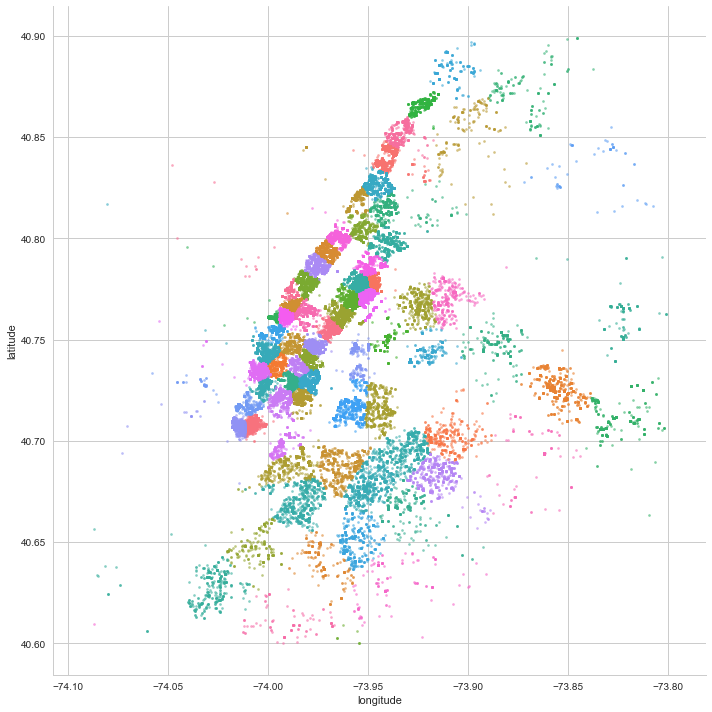

In [21]:
sns.lmplot(x='longitude', y='latitude', data=cluster_plot_df, hue='labels', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10,legend=False)

## Calculate avg price per cluster to add to features

In [22]:
#Aggregate Values by Cluster Label
label_avg_df=pd.DataFrame(cdf['price'].groupby(cdf['labels']).mean().reset_index())

In [23]:
label_avg_df.head()

,labels,price
0,0,3775.876518
1,1,2947.586207
2,2,2425.000000
3,3,500.000000
4,4,2200.000000


In [24]:
label_avg_df.columns=['labels','avg_price']

In [25]:
cdf = pd.merge(cdf, label_avg_df, on='labels')

In [26]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123265 entries, 0 to 123264
Data columns (total 18 columns):
bathrooms          123265 non-null float64
bedrooms           123265 non-null int64
building_id        123265 non-null object
created            123265 non-null object
description        123265 non-null object
display_address    123265 non-null object
features           123265 non-null object
interest_level     48606 non-null object
latitude           123265 non-null float64
listing_id         123265 non-null int64
longitude          123265 non-null float64
manager_id         123265 non-null object
photos             123265 non-null object
price              123265 non-null int64
street_address     123265 non-null object
test               123265 non-null bool
labels             123265 non-null int32
avg_price          123265 non-null float64
dtypes: bool(1), float64(4), int32(1), int64(3), object(9)
memory usage: 16.6+ MB


In [27]:
cdf.head(2).T

,0,1
bathrooms,1.5,1
bedrooms,3,1
building_id,53a5b119ba8f7b61d4e010512e0dfc85,0
created,2016-06-24 07:54:24,2016-04-18 03:31:04
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,GUT Renovated Greenpoint 1 bedroom with brand ...
display_address,Metropolitan Avenue,Meeker Avenue
features,[],[New Construction]
interest_level,medium,low
latitude,40.7145,40.7216
listing_id,7211212,6890059


## Add features from Created date, and NLP fields

In [28]:
#Adding Features
cdf['created']=pd.to_datetime(cdf['created'])
cdf['month']=cdf['created'].dt.month
cdf['weekday']=cdf['created'].dt.weekday
cdf["num_photos"] = cdf["photos"].apply(len)
cdf["num_features"] = cdf["features"].apply(len)
cdf["words_in_description"] = cdf["description"].apply(len)

In [29]:
#Recode variables Month, Weekday
cdf['month']=cdf['month'].astype('str')
cdf['weekday']=cdf['weekday'].astype('str')
df=pd.get_dummies(cdf[['month','weekday']])
df.head()

,month_4,month_5,month_6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,1,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0


In [30]:
cdf = cdf.merge(df,left_index=True, right_index=True)

In [31]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123265 entries, 0 to 123264
Data columns (total 33 columns):
bathrooms               123265 non-null float64
bedrooms                123265 non-null int64
building_id             123265 non-null object
created                 123265 non-null datetime64[ns]
description             123265 non-null object
display_address         123265 non-null object
features                123265 non-null object
interest_level          48606 non-null object
latitude                123265 non-null float64
listing_id              123265 non-null int64
longitude               123265 non-null float64
manager_id              123265 non-null object
photos                  123265 non-null object
price                   123265 non-null int64
street_address          123265 non-null object
test                    123265 non-null bool
labels                  123265 non-null int32
avg_price               123265 non-null float64
month                   123265 non-nul

## Derive features from numerical fields like Price per room and deviation of price from average price in cluster

In [32]:
#More Features
cdf['price_per_bed']=cdf['price']/cdf['bedrooms']
cdf['price_per_bath']=cdf['price']/cdf['bathrooms']
cdf['total_rooms']=cdf['bedrooms']+cdf['bathrooms']
cdf['price_per_room']=cdf['price']/cdf['total_rooms']
cdf['price_in_cluster']=cdf['price']-cdf['avg_price']

## Identify multi unit buildings by listing count per building

In [33]:
#Is it a building with multiple units
building_count_df=pd.DataFrame(cdf.groupby(cdf['building_id']).size().reset_index())

In [34]:
building_count_df.head()

,building_id,0
0,0,20563
1,00005cb939f9986300d987652c933e15,1
2,00024d77a43f0606f926e2312513845c,7
3,000ae4b7db298401cdae2b0ba1ea8146,2
4,0012f1955391bca600ec301035b97b65,1


In [35]:
building_count_df.columns=['building_id','unit_count']
building_count_df.head()

,building_id,unit_count
0,0,20563
1,00005cb939f9986300d987652c933e15,1
2,00024d77a43f0606f926e2312513845c,7
3,000ae4b7db298401cdae2b0ba1ea8146,2
4,0012f1955391bca600ec301035b97b65,1


In [36]:
cdf = pd.merge(cdf, building_count_df, on='building_id')

In [37]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123265 entries, 0 to 123264
Data columns (total 39 columns):
bathrooms               123265 non-null float64
bedrooms                123265 non-null int64
building_id             123265 non-null object
created                 123265 non-null datetime64[ns]
description             123265 non-null object
display_address         123265 non-null object
features                123265 non-null object
interest_level          48606 non-null object
latitude                123265 non-null float64
listing_id              123265 non-null int64
longitude               123265 non-null float64
manager_id              123265 non-null object
photos                  123265 non-null object
price                   123265 non-null int64
street_address          123265 non-null object
test                    123265 non-null bool
labels                  123265 non-null int32
avg_price               123265 non-null float64
month                   123265 non-nul

## Identify properties represented by high profile managers

In [38]:
#Does the manager have multiple listings
manager_count_df=pd.DataFrame(cdf.groupby(cdf['manager_id']).size().reset_index())

In [39]:
manager_count_df.columns=['manager_id','manager_popularity']
manager_count_df.head()

,manager_id,manager_popularity
0,0000abd7518b94c35a90d64b56fbf3e6,35
1,001ce808ce1720e24a9510e014c69707,28
2,003fc4e9a70053082f131b1054966aaf,4
3,00607a02f6efd9c6c7c588826e471ee9,11
4,00995ff28d79127ed2dca8320e9e7d09,9


In [40]:
cdf = pd.merge(cdf, manager_count_df, on='manager_id')

In [41]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123265 entries, 0 to 123264
Data columns (total 40 columns):
bathrooms               123265 non-null float64
bedrooms                123265 non-null int64
building_id             123265 non-null object
created                 123265 non-null datetime64[ns]
description             123265 non-null object
display_address         123265 non-null object
features                123265 non-null object
interest_level          48606 non-null object
latitude                123265 non-null float64
listing_id              123265 non-null int64
longitude               123265 non-null float64
manager_id              123265 non-null object
photos                  123265 non-null object
price                   123265 non-null int64
street_address          123265 non-null object
test                    123265 non-null bool
labels                  123265 non-null int32
avg_price               123265 non-null float64
month                   123265 non-nul

## Extract features from Features field

In [42]:
def feat(name, df, series):
    feature = pd.Series(0, df.index, name=name)
    for row, word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature
    return(df)

In [43]:
cdf = feat('Elevator', cdf, cdf.features)
cdf = feat('Dogs Allowed', cdf, cdf.features)
cdf = feat('Cats Allowed', cdf, cdf.features)
cdf = feat('laundry', cdf, cdf.features)
cdf = feat('stainless', cdf, cdf.features)
cdf = feat('hardwood', cdf, cdf.features)
cdf = feat('new', cdf, cdf.features)
cdf = feat('appliances', cdf, cdf.features)
cdf = feat('renovated', cdf, cdf.features)

In [44]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123265 entries, 0 to 123264
Data columns (total 49 columns):
bathrooms               123265 non-null float64
bedrooms                123265 non-null int64
building_id             123265 non-null object
created                 123265 non-null datetime64[ns]
description             123265 non-null object
display_address         123265 non-null object
features                123265 non-null object
interest_level          48606 non-null object
latitude                123265 non-null float64
listing_id              123265 non-null int64
longitude               123265 non-null float64
manager_id              123265 non-null object
photos                  123265 non-null object
price                   123265 non-null int64
street_address          123265 non-null object
test                    123265 non-null bool
labels                  123265 non-null int32
avg_price               123265 non-null float64
month                   123265 non-nul

In [45]:
cdf.head().T

,0,1,2,3,4
bathrooms,1.5,1,1,1.5,1
bedrooms,3,1,1,3,1
building_id,53a5b119ba8f7b61d4e010512e0dfc85,53a5b119ba8f7b61d4e010512e0dfc85,53a5b119ba8f7b61d4e010512e0dfc85,53a5b119ba8f7b61d4e010512e0dfc85,53a5b119ba8f7b61d4e010512e0dfc85
created,2016-06-24 07:54:24,2016-06-14 15:32:30,2016-06-24 05:46:50,2016-06-16 07:39:41,2016-06-20 19:00:04
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Enjoy These Following Apartment Features As Yo...,Enjoy These Following Apartment Features As Yo...,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Enjoy These Following Apartment Features As Yo...
display_address,Metropolitan Avenue,Metropolitan Avenue,Metropolitan Avenue,Metropolitan Avenue,Metropolitan Avenue
features,[],[],[],[],[]
interest_level,medium,low,low,NaN,NaN
latitude,40.7145,40.7145,40.7145,40.7145,40.7145
listing_id,7211212,7159209,7209396,7171949,7185456


## Recode clusters into categorical variables

In [46]:
#Recode variables labels
cdf['labels']=cdf['labels'].astype('str')
ldf=pd.get_dummies(cdf[['labels']])
ldf.head()

,labels_0,labels_1,labels_10,labels_11,labels_12,labels_13,labels_14,labels_15,labels_16,labels_17,...,labels_90,labels_91,labels_92,labels_93,labels_94,labels_95,labels_96,labels_97,labels_98,labels_99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
cdf = cdf.merge(ldf,left_index=True, right_index=True)
cdf.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,labels_90,labels_91,labels_92,labels_93,labels_94,labels_95,labels_96,labels_97,labels_98,labels_99
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-14 15:32:30,Enjoy These Following Apartment Features As Yo...,Metropolitan Avenue,[],low,40.7145,7159209,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 05:46:50,Enjoy These Following Apartment Features As Yo...,Metropolitan Avenue,[],low,40.7145,7209396,...,0,0,0,0,0,0,0,0,0,0
3,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-16 07:39:41,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],NaN,40.7145,7171949,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-20 19:00:04,Enjoy These Following Apartment Features As Yo...,Metropolitan Avenue,[],NaN,40.7145,7185456,...,0,0,0,0,0,0,0,0,0,0


## Drop unwanted features

In [48]:
cdf=cdf.drop(['building_id','created','description','display_address','features','manager_id','photos','street_address','labels','month','weekday','month_4','weekday_0','labels_99'],axis=1)

In [49]:
cdf.head(5).T

,0,1,2,3,4
bathrooms,1.5,1,1,1.5,1
bedrooms,3,1,1,3,1
interest_level,medium,low,low,NaN,NaN
latitude,40.7145,40.7145,40.7145,40.7145,40.7145
listing_id,7211212,7159209,7209396,7171949,7185456
longitude,-73.9425,-73.9425,-73.9425,-73.9425,-73.9425
price,3000,2500,2500,3000,2500
test,False,False,False,True,True
avg_price,2858.1,2858.1,2858.1,2858.1,2858.1
num_photos,5,5,5,5,5


## Setup train test dataframes for model

In [127]:
# train_cdf=cdf[cdf['test']==False]
test_cdf=cdf[cdf['test']==True]
train_cdf=train_cdf.drop('test',axis=1)
test_cdf=test_cdf.drop('test',axis=1)
test_cdf.shape

ValueError: labels ['test'] not contained in axis

In [51]:
train_cdf_index=train_cdf['listing_id']
train_cdf_target=train_cdf['interest_level']
train_cdf_inputs=train_cdf.drop(['listing_id','interest_level'],axis=1)
train_cdf_inputs = train_cdf_inputs.fillna(method='ffill')

In [52]:
train_cdf_inputs = Imputer().fit_transform(train_cdf_inputs)

In [106]:
test_cdf_index=test_cdf['listing_id'].values
test_cdf_inputs=test_cdf.drop(['listing_id','interest_level'],axis=1)

In [109]:
test_cdf_index

array([7171949, 7185456, 6855487, ..., 6931016, 7143646, 7028987], dtype=int64)

In [54]:
#Train Test Split
X_train,X_val,Y_train,Y_val=train_test_split(train_cdf_inputs,train_cdf_target,test_size=0.2,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(38884, 129) (9722, 129) (38884,) (9722,)


## Setup target variable for log loss calculation

In [55]:
#Setup Y_test for Log Loss scoring
Y_val_onehot = pd.get_dummies(Y_val)
Y_val_onehot.head()

,high,low,medium
80530,0,0,1
16558,0,0,1
6245,0,1,0
16954,0,1,0
52923,0,1,0


## Spot check possible models with K Fold CV

In [56]:
num_folds=10
num_instances=len(X_train)
seed=7
scoring='accuracy'

In [57]:
#Spot Check Algorithms
models=[]
models.append(('LR',LogisticRegressionCV(multi_class='multinomial')))
models.append(('RF',RandomForestClassifier(criterion='entropy',n_estimators=500,verbose=False,max_depth=18)))

In [59]:
results=[]
names=[]
for name, model in models:
    kfold=KFold(n=num_instances,n_folds=num_folds,random_state=seed)
    cv_results=cross_val_score(model,X_train,Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg="%s: %f (%f)" %(name, cv_results.mean(),cv_results.std())
    print(msg)

LR: 0.694193 (0.006284)
RF: 0.717519 (0.006182)


## Logistic Regression

In [60]:
#Logistic Regression
lr=LogisticRegressionCV(cv=3, multi_class='multinomial', verbose=2, scoring='accuracy', max_iter=5000)
lr.fit(X_train,Y_train)
y_pred=lr.predict_proba(X_val)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min finished


In [61]:
y_pred.shape

(9722, 3)

In [63]:
#print("LR: Accuracy Score:",accuracy_score(y_pred,Y_test))
print("LR: Log Loss:", log_loss(Y_val_onehot,y_pred))

LR: Log Loss: 0.666306909276


## Decision Tree

In [ ]:
## Decision Tree
tree=DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
tree.fit(X_train,Y_train)
y_pred=tree.predict_proba(X_val)

In [66]:
print("Tree: Log Loss:", log_loss(Y_val_onehot,y_pred))

Tree: Log Loss: 0.686603940041


## Random Forest

In [67]:
#Random Forest
forest=RandomForestClassifier(criterion='entropy',n_estimators=500,verbose=False,max_depth=18)
forest.fit(X_train,Y_train)
y_pred=forest.predict_proba(X_val)

In [68]:
print("Forest: Log Loss:", log_loss(Y_val_onehot,y_pred))

Forest: Log Loss: 0.605047481667


## Feature Importances

In [119]:
print(list(train_cdf_inputs))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Feature ranking:
1. feature 4 (0.124738)
2. feature 19 (0.105374)
3. feature 18 (0.098034)
4. feature 8 (0.071092)
5. feature 2 (0.061326)
6. feature 6 (0.060536)
7. feature 20 (0.059893)
8. feature 3 (0.059683)
9. feature 7 (0.048208)
10. feature 5 (0.039023)
11. feature 1 (0.035908)
12. feature 17 (0.035348)
13. feature 0 (0.013195)
14. feature 10 (0.012108)
15. feature 9 (0.012055)
16. feature 21 (0.011358)
17. feature 22 (0.009743)
18. feature 23 (0.009449)
19. feature 12 (0.009354)
20. feature 11 (0.008991)
21. feature 14 (0.008894)
22. feature 13 (0.008823)
23. feature 15 (0.007797)
24. feature 16 (0.006820)
25. feature 73 (0.002922)
26. feature 107 (0.002283)
27. feature 97 (0.002225)
28. feature 113 (0.002122)
29. feature 118 (0.001946)
30. feature 92 (0.001835)
31. feature 117 (0.001750)
32. feature 87 (0.001729)
33. feature 33 (0.001679)
34. feature 57 (0.001676)
35. feature 82 (0.001670)
36. feature 106 (0.001629)
37. feature 79 (0.001552)
38. feature 30 (0.001535)
39. featu

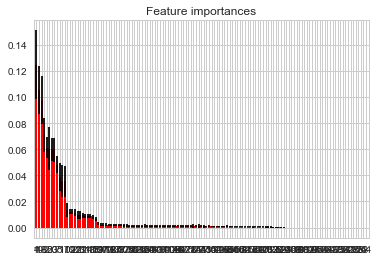

In [74]:
importances=forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Grid Search

In [76]:
grid_search_params = dict(n_estimators=[100,1000], 
                          max_depth=[None,10,20], 
                          class_weight=[None, 'balanced'])
rfc = RandomForestClassifier()
gs = GridSearchCV(estimator=rfc, param_grid=grid_search_params, n_jobs=3, verbose=10)

gs.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   16.6s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  8.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'class_weight': [None, 'balanced'], 'n_estimators': [100, 1000], 'max_depth': [None, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [77]:
print("Best params: ", gs.best_params_)
print("Best score: ", gs.best_score_)

Best params:  {'class_weight': None, 'n_estimators': 1000, 'max_depth': None}
Best score:  0.7245910914514968


In [91]:
y_pred = gs.predict(X_val)
y_pred

array(['low', 'low', 'low', ..., 'low', 'medium', 'low'], dtype=object)

In [92]:
classes = gs.best_estimator_.classes_
classes

array(['high', 'low', 'medium'], dtype=object)

## Classification Matrix

In [93]:
print(classification_report(Y_val, y_pred))

             precision    recall  f1-score   support

       high       0.54      0.25      0.34       702
        low       0.78      0.94      0.85      6783
     medium       0.50      0.28      0.36      2237

avg / total       0.70      0.74      0.70      9722



In [94]:
print(accuracy_score(Y_val, y_pred))

0.735548241103


## Run model on test dataset and prep for submission to Kaggle

In [110]:
test_cdf_inputs = Imputer().fit_transform(test_cdf_inputs)

In [111]:
target_prob = pd.DataFrame(data=gs.predict_proba(test_cdf_inputs), columns=gs.best_estimator_.classes_)

In [112]:
target_prob['listing_id'] = test_cdf_index
target_prob.head(10)

,high,low,medium,listing_id
0,0.038000,0.438550,0.523450,7171949
1,0.010000,0.911000,0.079000,7185456
2,0.023000,0.848000,0.129000,6855487
3,0.017000,0.854500,0.128500,6873373
4,0.038000,0.833167,0.128833,6902233
5,0.013667,0.892167,0.094167,6873033
6,0.105000,0.565000,0.330000,6937777
7,0.070500,0.333000,0.596500,6910712
8,0.039000,0.316667,0.644333,6855602
9,0.099000,0.616000,0.285000,6854624


In [113]:
target_prob.to_csv("rf1.csv", index=False)

### Kaggle Score 0.60922